### Turtles and Penguins Binary Classifier with Transfer Learning (EfficientNetV2L)
#### Written by Dhruv Agrawal and Ariel Huang
#### COMP9517 Team Slayer Group Project

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from tensorflow.python.training.saver import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
PATH_TO_TRAIN_IMAGES = "data/crop/train/"
PATH_TO_VALIDATION_IMAGES = "data/crop/val/"
PATH_TO_TEST_IMAGES = "data/crop/test/"

In [63]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TO_TRAIN_IMAGES,
    batch_size=32,
    image_size=(96, 96)
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TO_VALIDATION_IMAGES,
    batch_size=32,
    image_size=(96, 96)
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TO_TEST_IMAGES,
    batch_size=32,
    image_size=(96, 96)
)

class_names = train_dataset.class_names
print(class_names)

Found 4500 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Found 72 files belonging to 2 classes.
['penguin', 'turtle']


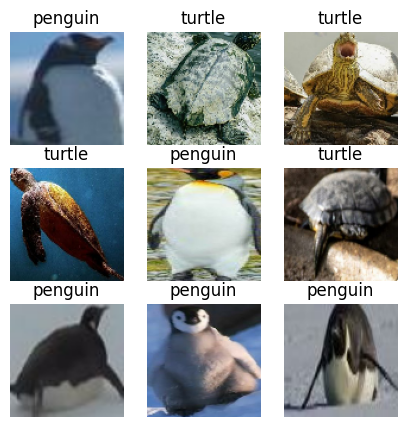

In [4]:
plt.figure(figsize=(5,5))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
    for row in range(9):
        plt.subplot(3, 3, row + 1)
        plt.imshow(images[row].numpy().astype("uint8"))
        plt.title(class_names[labels[row]])
        plt.axis("off")

In [6]:
# buffered prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [38]:
IMG_SHAPE = (96, 96) + (3,)
base_model = tf.keras.applications.EfficientNetV2L(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
base_model.summary()

Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 96, 96, 3)            0         ['input_5[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 48, 48, 32)           864       ['rescaling_2[0][0]']         
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 48, 48, 32)           128       ['stem_conv[0][0]']           
 n)                                                                                

In [39]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=(96, 96, 3))

output = base_model(inputs)
output = global_average_layer(output)
output = prediction_layer(output)
output = tf.keras.layers.Dropout(0.2)(output)

model = tf.keras.Model(inputs, output)

In [40]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-l (Function  (None, 3, 3, 1280)        117746848 
 al)                                                             
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
 dropout_2 (Dropout)         (None, 1)                 0         
                                                                 
Total params: 117748129 (449.17 MB)
Trainable params: 1281 

In [41]:
hist = model.fit(train_dataset, validation_data=val_dataset, batch_size=32, epochs=50)

Epoch 1/50
16/16 [==============================] - 28s 932ms/step - loss: 0.5687 - accuracy: 0.6540 - val_loss: 0.3863 - val_accuracy: 0.9231
Epoch 2/50
16/16 [==============================] - 12s 760ms/step - loss: 0.3483 - accuracy: 0.8380 - val_loss: 0.2960 - val_accuracy: 0.9038
Epoch 3/50
16/16 [==============================] - 15s 929ms/step - loss: 0.2713 - accuracy: 0.8800 - val_loss: 0.1431 - val_accuracy: 1.0000
Epoch 4/50
16/16 [==============================] - 13s 784ms/step - loss: 0.2417 - accuracy: 0.9100 - val_loss: 0.1368 - val_accuracy: 1.0000
Epoch 5/50
16/16 [==============================] - 12s 727ms/step - loss: 0.2388 - accuracy: 0.8720 - val_loss: 0.0964 - val_accuracy: 0.9808
Epoch 6/50
16/16 [==============================] - 12s 720ms/step - loss: 0.2314 - accuracy: 0.9060 - val_loss: 0.0862 - val_accuracy: 1.0000
Epoch 7/50
16/16 [==============================] - 11s 710ms/step - loss: 0.1974 - accuracy: 0.8880 - val_loss: 0.0861 - val_accuracy: 0.9808

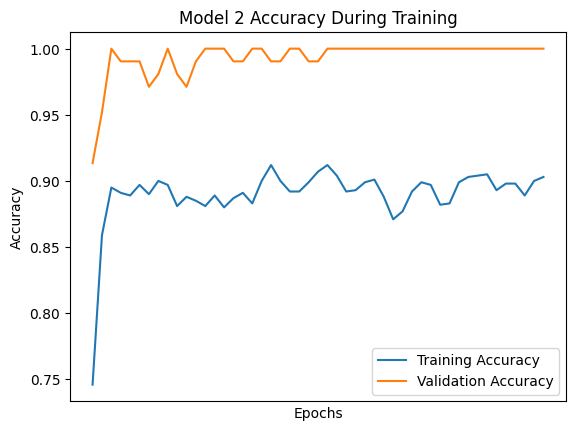

In [60]:
def moving_average(values, smoothing_over_epochs):
    return np.convolve(values, np.ones(smoothing_over_epochs), 'valid') / smoothing_over_epochs

AVERAGING = 2

train_accs = hist.history['accuracy']
train_graph = moving_average(train_accs, AVERAGING)
epoch_range = [x + 1 for x in range(len(train_graph))]

validation_accs = hist.history['val_accuracy']
val_graph = moving_average(validation_accs, AVERAGING)
epoch_range = [x + 1 for x in range(len(val_graph))]

plt.plot(np.asarray(epoch_range).astype(str), train_graph, label='Training Accuracy')
plt.plot(np.asarray(epoch_range).astype(str), val_graph, label='Validation Accuracy')
plt.xticks([])
plt.title('Model 2 Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Ground Truth Labels:
 [1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1]
Model Predictions:
 [1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1]



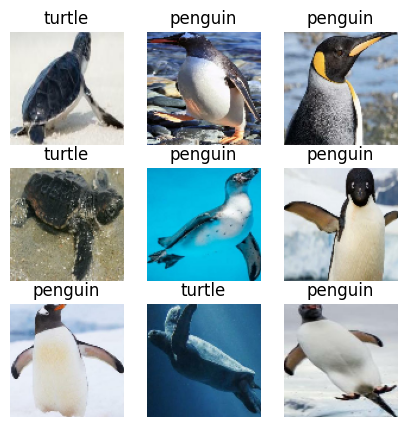

In [43]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Actual Labels:\n', label_batch)
print('Predicted Labels:\n', predictions.numpy())

plt.figure(figsize=(5, 5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

1/1 [==============================] - 0s 237ms/step


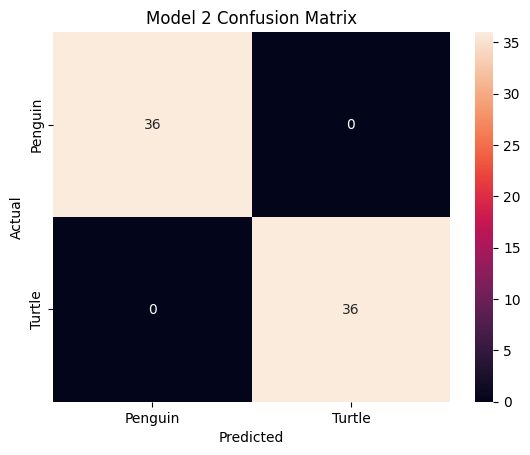

In [62]:
y_pred = []
y_true = []
for images, labels in test_dataset:
    y_pred.extend(tf.nn.sigmoid(model.predict(images)).numpy().flatten())
    y_true.extend(labels.numpy().flatten())

y_pred = np.asarray(y_pred)
y_pred = np.where(y_pred < 0.5, 0, 1)


sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, xticklabels=['Penguin', 'Turtle'], yticklabels=['Penguin', 'Turtle'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Model 2 Confusion Matrix')
plt.show()

In [46]:
# classification report
print('Classification Report')
print(sklearn.metrics.classification_report(y_true, y_pred, target_names=['Penguin', 'Turtle']))

Classification Report
              precision    recall  f1-score   support

     Penguin       1.00      1.00      1.00        36
      Turtle       1.00      1.00      1.00        36

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



In [47]:
# save the model
model.save('demo_neural_net')

INFO:tensorflow:Assets written to: demo_neural_net/assets


INFO:tensorflow:Assets written to: demo_neural_net/assets
